In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pickle
import forestci as fci
import matplotlib.pyplot as plt
from infodengue import get_cluster_data, get_city_names, combined_data, get_alerta_table
from predict_settings import *
from skgarden import RandomForestQuantileRegressor

Failed to import duecredit due to No module named 'duecredit'


In [24]:
quantile=10

In [25]:
def get_cities_from_state(state):
    alerta_table = get_alerta_table(state=state)
    cities_list = alerta_table.municipio_geocodigo.unique()
    return cities_list


In [26]:
def build_model(**kwargs):
    model= RandomForestQuantileRegressor(random_state=0, min_samples_split=10, n_estimators=1000,n_jobs=-1)
    #model = RandomForestRegressor(max_depth=None, random_state=0, n_jobs=-1,
    #                             n_estimators=1000,
    #                              warm_start=True)
    return model

In [27]:
def build_lagged_features(dt, lag=2, dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    :param dt: Dataframe containing features
    :param lag: maximum lags to compute
    :param dropna: if true the initial rows containing NANs due to lagging will be dropped
    :return: Dataframe
    '''
    if type(dt) is pd.DataFrame:
        new_dict = {}
        for col_name in dt:
            new_dict[col_name] = dt[col_name]
            # create lagged Series
            for l in range(1, lag + 1):
                new_dict['%s_lag%d' % (col_name, l)] = dt[col_name].shift(l)
        res = pd.DataFrame(new_dict, index=dt.index)

    elif type(dt) is pd.Series:
        the_range = range(lag + 1)
        res = pd.concat([dt.shift(-i) for i in the_range], axis=1)
        res.columns = ['lag_%d' % i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [28]:
def rolling_forecasts(data, target, window=12, horizon=1):
    """
    Fits the rolling forecast model
    :param data: feature Dataframe
    :param window: lookback window
    :param horizon: forecast horizon
    :param target: variable to be forecasted
    :return:
    """
    model = build_model()
    model.fit(data.values, target)
    # for i in range(0, ldf.shape[0] - window):
    #     model.fit(ldf.values[i:i + window, :], ldf['target'].values[i:i + window])

    return model

In [29]:
def calculate_metrics(pred, ytrue):
    return [mean_absolute_error(ytrue, pred, ), explained_variance_score(ytrue, pred),
            mean_squared_error(ytrue, pred), mean_squared_log_error(ytrue, pred),
            median_absolute_error(ytrue, pred), r2_score(ytrue, pred)]

In [30]:
def plot_prediction(preds, ydata, title, train_size, path='random_forest'):
    plt.clf()
    plt.plot(ydata, 'k-')

    point = ydata.index[train_size]

    min_val = min([min(ydata), np.nanmin(preds)])
    max_val = max([max(ydata), np.nanmax(preds)])
    plt.vlines(point, min_val, max_val, 'g', 'dashdot', lw=2)

    pred_window = preds.shape[1]
    llist = range(len(ydata.index) - (preds.shape[1]))
    print(type(preds))

    # # for figure with all predicted points
    # for n in llist:
    #     plt.vlines(ydata.index[n + pred_window], 0, preds[n][-1], 'b', alpha=0.2)
    #     plt.plot(ydata.index[n:n + pred_window], preds[n], 'r')

    # for figure with only the last prediction point (single red line)
    x = []
    y = []
    for n in llist:
        plt.vlines(ydata.index[n + pred_window], 0, preds[n][-1], 'b', alpha=0.2)
        x.append(ydata.index[n+pred_window])
        y.append(preds[n][-1])
    plt.plot(x, y, 'r-', alpha=0.7)

    plt.text(point, 0.6 * max_val, "Out of sample Predictions")
    plt.grid()
    plt.ylabel('indices')
    plt.legend(loc=0)
    plt.title('Predictions for {}'.format(title))
    plt.xticks(rotation=70)
    plt.legend(['data', 'predicted'])

    plt.savefig('saved_models/{}/{}/rf_{}_ss.png'.format(path, STATE, title), dpi=300)
    plt.show()
    return None

def confidence_interval(model, Xtrain, Xtest):
    inbag = fci.calc_inbag(Xtrain.shape[0], model)
    ci = fci.random_forest_error(model, Xtrain.values, Xtest.values, inbag=inbag)
    return ci

In [31]:
def rf_prediction(city, state, horizon, lookback):
    with open('../analysis/clusters_{}.pkl'.format(state), 'rb') as fp:
        clusters = pickle.load(fp)
    data, group = get_cluster_data(city, clusters=clusters, data_types=DATA_TYPES, cols=PREDICTORS)

    target = 'casos_est_{}'.format(city)
    casos_est_columns = ['casos_est_{}'.format(i) for i in group]
    # casos_columns = ['casos_{}'.format(i) for i in group]

    # data = data_full.drop(casos_columns, axis=1)
    data_lag = build_lagged_features(data, lookback)
    data_lag.dropna()
    targets = {}
    for d in range(1, horizon + 1):
        if d == 1:
            targets[d] = data_lag[target].shift(-(d - 1))
        else:
            targets[d] = data_lag[target].shift(-(d - 1))[:-(d - 1)]

    X_data = data_lag.drop(casos_est_columns, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_data, data_lag[target],
                                                        train_size=0.7, test_size=0.3, shuffle=False)

    city_name = get_city_names([city, 0])[0][1]
    preds = np.empty((len(data_lag), horizon))
    metrics = pd.DataFrame(index=('mean_absolute_error', 'explained_variance_score',
                                  'mean_squared_error', 'mean_squared_log_error',
                                  'median_absolute_error', 'r2_score'))
    for d in range(1, horizon + 1):
        tgt = targets[d][:len(X_train)]
        tgtt = targets[d][len(X_train):]

        model = rolling_forecasts(X_train, target=tgt, horizon=horizon)
        pred = model.predict(X_data[:len(targets[d])],quantile=quantile)

        dif = len(data_lag) - len(pred)
        if dif > 0:
            pred = list(pred) + ([np.nan] * dif)
        preds[:, (d - 1)] = pred

        pred_m = model.predict(X_test[(d - 1):],quantile=quantile)
        metrics[d] = calculate_metrics(pred_m, tgtt)

    metrics.to_pickle('{}/{}/rf_metrics_{}.pkl'.format('saved_models/random_forest', state, city))
    plot_prediction(preds, targets[1], city_name, len(X_train))

    return preds, X_train, targets, data_lag

In [32]:
def rf_single_state_prediction(state, lookback, horizon, predictors):
    # # RF WITHOUT CLUSTER SERIES
    if state == "CE":
        s = 'Ceará'
    else:
        s = state
    cities = list(get_cities_from_state(s))

    for city in cities:
        if os.path.isfile('/saved_models/random_forest_no_cluster/{}/rf_metrics_{}.pkl'.format(state, city)):
            print(city, 'done')
            continue
        data = combined_data(city, DATA_TYPES)
        data = data[predictors]
        data.drop('casos', axis=1, inplace=True)

        target = 'casos_est'
        data_lag = build_lagged_features(data, lookback)
        data_lag.dropna()
        targets = {}
        for d in range(1, horizon + 1):
            if d == 1:
                targets[d] = data_lag[target].shift(-(d - 1))
            else:
                targets[d] = data_lag[target].shift(-(d - 1))[:-(d - 1)]

        X_data = data_lag.drop(target, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_data, data_lag[target],
                                                            train_size=0.7, test_size=0.3, shuffle=False)

        city_name = get_city_names([city, 0])[0][1]
        preds = np.empty((len(data_lag), horizon))
        metrics = pd.DataFrame(index=('mean_absolute_error', 'explained_variance_score',
                                      'mean_squared_error', 'mean_squared_log_error',
                                      'median_absolute_error', 'r2_score'))
        for d in range(1, horizon + 1):
            tgt = targets[d][:len(X_train)]
            tgtt = targets[d][len(X_train):]

            model = rolling_forecasts(X_train, target=tgt, horizon=horizon)
            pred = model.predict(X_data[:len(targets[d])],quantile=quantile)

            dif = len(data_lag) - len(pred)
            if dif > 0:
                pred = list(pred) + ([np.nan] * dif)
            preds[:, (d - 1)] = pred

            pred_m = model.predict(X_test[(d - 1):])
            metrics[d] = calculate_metrics(pred_m, tgtt)

        metrics.to_pickle('{}/{}/rf_metrics_{}.pkl'.format('saved_models/random_forest_no_cluster', state, city))
        plot_prediction(preds, targets[1], city_name, len(X_train))
        # plt.show()
    return None

In [33]:
def rf_state_prediction(state, lookback, horizon, predictors):
    clusters = pd.read_pickle('../analysis/clusters_{}.pkl'.format(state))

    for cluster in clusters:
        data_full, group = get_cluster_data(geocode=cluster[0], clusters=clusters,
                                       data_types=DATA_TYPES, cols=predictors)
        for city in cluster:
            if os.path.isfile('/home/elisa/Documentos/InfoDenguePredict/infodenguepredict/models/saved_models/{}/rf_metrics_{}.pkl'.format(state, city)):
                print('done')
                continue

            target = 'casos_est_{}'.format(city)
            casos_est_columns = ['casos_est_{}'.format(i) for i in group]
            # casos_columns = ['casos_{}'.format(i) for i in group]

            # data = data_full.drop(casos_columns, axis=1)
            data_lag = build_lagged_features(data_full, lookback)
            data_lag.dropna()
            targets = {}
            for d in range(1, horizon + 1):
                if d == 1:
                    targets[d] = data_lag[target].shift(-(d - 1))
                else:
                    targets[d] = data_lag[target].shift(-(d - 1))[:-(d - 1)]

            X_data = data_lag.drop(casos_est_columns, axis=1)
            X_train, X_test, y_train, y_test = train_test_split(X_data, data_lag[target],
                                                                train_size=0.7, test_size=0.3, shuffle=False)

            city_name = get_city_names([city, 0])[0][1]
            preds = np.empty((len(data_lag), horizon))
            metrics = pd.DataFrame(index=('mean_absolute_error', 'explained_variance_score',
                                          'mean_squared_error', 'mean_squared_log_error',
                                          'median_absolute_error', 'r2_score'))
            for d in range(1, horizon + 1):
                tgt = targets[d][:len(X_train)]
                tgtt = targets[d][len(X_train):]

                model = rolling_forecasts(X_train, target=tgt, horizon=horizon)
                pred = model.predict(X_data[:len(targets[d])],quantile=quantile)

                dif = len(data_lag) - len(pred)
                if dif > 0:
                    pred = list(pred) + ([np.nan] * dif)
                preds[:, (d - 1)] = pred

                pred_m = model.predict(X_test[(d-1):])
                metrics[d] = calculate_metrics(pred_m, tgtt)

            metrics.to_pickle('{}/{}/rf_metrics_{}.pkl'.format('saved_models/random_forest', state, city))
            plot_prediction(preds, targets[1], city_name, len(X_train))
            # plt.show()
    return None

C:\Users\marcelo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1062: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


<class 'numpy.ndarray'>


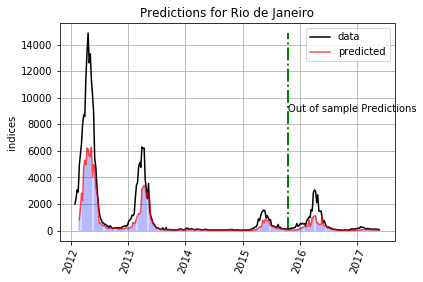

In [34]:
if __name__ == "__main__":
    # target = 'casos_est_{}'.format(CITY)
    # preds = rf_prediction(CITY, STATE, target, PREDICTION_WINDOW, LOOK_BACK)
    # for STATE in ['RJ', 'PR', 'CE']:
        # rf_state_prediction(STATE, LOOK_BACK, PREDICTION_WINDOW, PREDICTORS)
        # rf_single_state_prediction(STATE, LOOK_BACK, PREDICTION_WINDOW, PREDICTORS)

    rf_prediction(CITY, STATE, horizon=PREDICTION_WINDOW, lookback=LOOK_BACK)